In [21]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from typing import NamedTuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.corr import auto_correlation_matrix, get_significant_correlations
from utils.tableone import compute_tableone, filter_tableone

PROJECT_PATH = Path('.').absolute().parents[0]
DATA_PATH = Path(PROJECT_PATH, 'raw')

print('Project path: ', PROJECT_PATH)
print('Data path: ', DATA_PATH)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project path:  /Users/taehyun/project/side-projects/data/dunnhumby
Data path:  /Users/taehyun/project/side-projects/data/dunnhumby/raw


# Exploration for Dunnhumby The-Complete-Journey

## Table of Contents

1. [Household Demographics](#1.-Household-Demographics)
   - 1.1 Data Loading & Overview
   - 1.2 Distributions
   - 1.3 Correlation Analysis
2. [Transaction Patterns](#2.-Transaction-Patterns)
   - 2.1 Data Loading & Cleaning
   - 2.2 Household-level Analysis
   - 2.3 Store-level Analysis
   - 2.4 Basket-level Analysis
   - 2.5 Time Trends
   - 2.6 Value-Frequency Segments
   - 2.7 Discount Sensitivity

## Data Overview

**Data table**
- campaign_table
- transaction_data
- hh_demographic

**Lookup table**
- campaign_desc
- coupon
- coupon_redempt
- product


```
hh_demographic ──┐
                 │
                 ├─→ transaction_data ←─→ product
                 │         ↓
campaign_table ──┘         ↓
      ↓              causal_data
campaign_desc            
      ↓
    coupon ←──→ coupon_redempt
```

In [2]:
list(map(lambda pth: pth.name, DATA_PATH.rglob('*.csv')))

['hh_demographic.csv',
 'causal_data.csv',
 'coupon.csv',
 'campaign_table.csv',
 'coupon_redempt.csv',
 'product.csv',
 'campaign_desc.csv',
 'transaction_data.csv']

## 1. Household Demographics (`hh_demographic`)

### 1.1 Data Loading & Overview

In [3]:
column_mapping = {
    'classification_1': 'AGE_GRP',
    'classification_2': 'MARITAL',
    'classification_3': 'INCOME_GRP',
    'classification_4': 'HOUSEHOLD_SIZE',
    'classification_5': 'HOUSEHOLD_COMPOSITION',
    'HOMEOWNER_DESC': 'HOMEOWNER_DESC',
    'KID_CATEGORY_DESC': 'KID_CATEGORY_DESC',
}

df_demo = pd.read_csv(
    DATA_PATH / 'hh_demographic.csv'
).rename(columns=column_mapping)
                                                                                                                        
df_demo.head()                                                                                              

,AGE_GRP,MARITAL,INCOME_GRP,HOMEOWNER_DESC,HOUSEHOLD_COMPOSITION,HOUSEHOLD_SIZE,KID_CATEGORY_DESC,household_key
0,Age Group6,X,Level4,Homeowner,Group5,2,None/Unknown,1
1,Age Group4,X,Level5,Homeowner,Group5,2,None/Unknown,7
2,Age Group2,Y,Level3,Unknown,Group4,3,1,8
3,Age Group2,Y,Level6,Homeowner,Group4,4,2,13
4,Age Group4,Z,Level5,Homeowner,Group3,1,None/Unknown,16


In [4]:
len(df_demo)

801

In [5]:
df_demo.isnull().sum().to_frame().T

,AGE_GRP,MARITAL,INCOME_GRP,HOMEOWNER_DESC,HOUSEHOLD_COMPOSITION,HOUSEHOLD_SIZE,KID_CATEGORY_DESC,household_key
0,0,0,0,0,0,0,0,0


### 1.2 Distributions

In [6]:
fn_cat_grp_cnt = lambda col: (
    df_demo.groupby(by=col)['household_key'].count().to_frame().assign(**{
        'count': lambda elem: elem['household_key'],
        'proportion': lambda elem: elem['household_key'] / len(df_demo)
    }).drop('household_key', axis=1)
)

for col in df_demo.columns[:-1]:
    print('=====' * 5, col)
    print(fn_cat_grp_cnt(col).round(3).to_markdown())
    print(' \n')

========================= AGE_GRP
| AGE_GRP    |   count |   proportion |
|:-----------|--------:|-------------:|
| Age Group1 |      46 |        0.057 |
| Age Group2 |     142 |        0.177 |
| Age Group3 |     194 |        0.242 |
| Age Group4 |     288 |        0.36  |
| Age Group5 |      59 |        0.074 |
| Age Group6 |      72 |        0.09  |
 

========================= MARITAL
| MARITAL   |   count |   proportion |
|:----------|--------:|-------------:|
| X         |     340 |        0.424 |
| Y         |     344 |        0.429 |
| Z         |     117 |        0.146 |
 

========================= INCOME_GRP
| INCOME_GRP   |   count |   proportion |
|:-------------|--------:|-------------:|
| Level1       |      61 |        0.076 |
| Level10      |      11 |        0.014 |
| Level11      |       5 |        0.006 |
| Level12      |      11 |        0.014 |
| Level2       |      74 |        0.092 |
| Level3       |      77 |        0.096 |
| Level4       |     172 |        0.21

### 1.3 Correlation Analysis

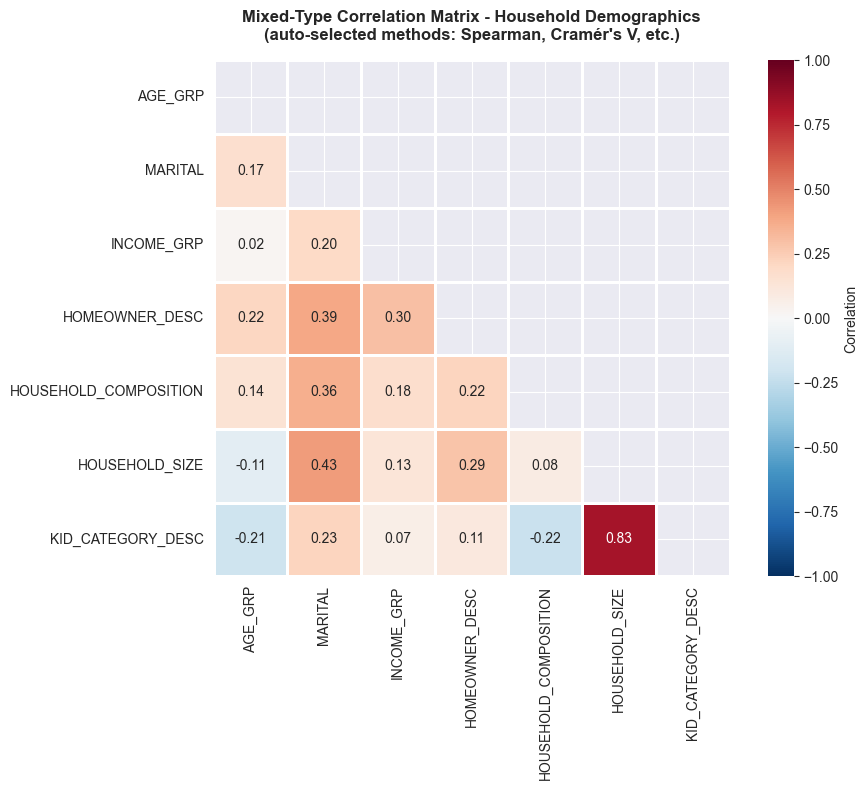


CORRELATION METHODS USED
|                | AGE_GRP   | MARITAL   | INCOME_GRP   | HOMEOWNER_DESC   |
|:---------------|:----------|:----------|:-------------|:-----------------|
| AGE_GRP        | -         | cramers_v | spearman     | spearman         |
| MARITAL        | cramers_v | -         | cramers_v    | cramers_v        |
| INCOME_GRP     | spearman  | cramers_v | -            | spearman         |
| HOMEOWNER_DESC | spearman  | cramers_v | spearman     | -                |

SIGNIFICANT CORRELATIONS (|r| > 0.3 and p < 0.05)
| var1           | var2                  |   correlation |        p_value | method    |
|:---------------|:----------------------|--------------:|---------------:|:----------|
| HOUSEHOLD_SIZE | KID_CATEGORY_DESC     |      0.829595 |   2.08751e-204 | spearman  |
| MARITAL        | HOUSEHOLD_SIZE        |      0.427818 | nan            | cramers_v |
| MARITAL        | HOMEOWNER_DESC        |      0.387445 | nan            | cramers_v |
| MARITAL        | HO

In [7]:
ordinal_orders = {
    'AGE_GRP': ['Age Group1', 'Age Group2', 'Age Group3', 'Age Group4', 'Age Group5', 'Age Group6'],
    'INCOME_GRP': [f'Level{i}' for i in range(1, 13)],
    'HOMEOWNER_DESC': ['Renter', 'Probable Renter', 'Unknown', 'Probable Owner', 'Homeowner'],
    'HOUSEHOLD_COMPOSITION': [f'Group{i}' for i in range(1, 7)],
    'HOUSEHOLD_SIZE': ['1', '2', '3', '4', '5+'],
    'KID_CATEGORY_DESC': ['None/Unknown', '1', '2', '3+']
}


type_overrides = {
    'AGE_GRP': 'ordinal',
    'MARITAL': 'categorical',
    'INCOME_GRP': 'ordinal',
    'HOMEOWNER_DESC': 'ordinal',
    'HOUSEHOLD_COMPOSITION': 'ordinal',
    'HOUSEHOLD_SIZE': 'ordinal',
    'KID_CATEGORY_DESC': 'ordinal'
}

demo_cols = ['AGE_GRP', 'MARITAL', 'INCOME_GRP', 'HOMEOWNER_DESC', 'HOUSEHOLD_COMPOSITION', 'HOUSEHOLD_SIZE', 'KID_CATEGORY_DESC']
corr_df = auto_correlation_matrix(
    df_demo,
    columns=demo_cols,
    ordinal_overrides=ordinal_orders,
    type_overrides=type_overrides
)

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(
    corr_df, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
    center=0, vmin=-1, vmax=1, square=True, linewidths=1,
    cbar_kws={'label': 'Correlation'}, ax=ax
)
plt.title('Mixed-Type Correlation Matrix - Household Demographics\n(auto-selected methods: Spearman, Cramér\'s V, etc.)', 
          fontsize=12, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CORRELATION METHODS USED")
print("="*60)
print(corr_df.attrs['methods'].iloc[:4, :4].to_markdown())

sig_corrs = get_significant_correlations(corr_df, threshold=0.3, p_threshold=0.05)
print("\n" + "="*60)
print("SIGNIFICANT CORRELATIONS (|r| > 0.3 and p < 0.05)")
print("="*60)
if len(sig_corrs) > 0:
    print(sig_corrs.to_markdown(index=False))
else:
    print("No significant correlations found.")

**Summary: Household Demographics**
- **801 households** with demographic data (32% of total 2,500)
- **No missing values** across all demographic variables
- **Key distributions:**
  - `AGE_GRP`: Group4 dominant (36%), Group3 second (24%)
  - `INCOME_GRP`: Level4-5 most common (46%), long tail in higher levels
  - `HOMEOWNER_DESC`: 63% Homeowners, 29% Unknown
  - `HOUSEHOLD_SIZE`: 1-2 person households dominate (72%)
  - `KID_CATEGORY_DESC`: 70% None/Unknown
- **Significant correlations (|r| > 0.3):**
  - `HOUSEHOLD_SIZE` ↔ `KID_CATEGORY_DESC`: 0.84 (strong)
  - `HOUSEHOLD_SIZE` ↔ `HOUSEHOLD_COMPOSITION`: 0.68
  - `AGE_GRP` ↔ `INCOME_GRP`: 0.32

## 2. Transaction Patterns

### 2.1 Data Loading & Cleaning

**Loyalty card price (after loyalty discount)**
loyalty_price = (sales_value - (retail_disc + coupon_match_disc)) / quantity

**Non-loyalty card price (shelf price)**
regular_price = (sales_value - coupon_match_disc) / quantity

**Actual amount customer paid (when using coupon)**
customer_paid = sales_value - coupon_disc

In [8]:
df_trans = pd.read_csv(
    DATA_PATH / 'transaction_data.csv'
)

df_trans.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [9]:
df_trans[['DAY', 'WEEK_NO', 'QUANTITY', 'SALES_VALUE', 'RETAIL_DISC', 'TRANS_TIME', 'COUPON_DISC', 'COUPON_MATCH_DISC']].describe().round(3)

# outliers.. 
# 1. Quantity == 0
# 2. RETAIL_DISC > 0

,DAY,WEEK_NO,QUANTITY,SALES_VALUE,RETAIL_DISC,TRANS_TIME,COUPON_DISC,COUPON_MATCH_DISC
count,2595732.000,2595732.000,2595732.000,2595732.000,2595732.000,2595732.000,2595732.000,2595732.000
mean,388.756,56.221,100.429,3.104,-0.539,1561.586,-0.016,-0.003
std,189.721,27.102,1153.436,4.182,1.249,399.838,0.217,0.040
min,1.000,1.000,0.000,0.000,-180.000,0.000,-55.930,-7.700
25%,229.000,33.000,1.000,1.290,-0.690,1308.000,0.000,0.000
50%,390.000,56.000,1.000,2.000,-0.010,1613.000,0.000,0.000
75%,553.000,80.000,1.000,3.490,0.000,1843.000,0.000,0.000
max,711.000,102.000,89638.000,840.000,3.990,2359.000,0.000,0.000


In [10]:
df_trans.isnull().sum().to_frame().T

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
df_trans[df_trans['QUANTITY'] == 0].head() # outliers

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
97,744,26985165432,1,5978648,0,0.0,31582,0.0,1119,1,0.0,0.0
128,1287,26985336468,1,5978648,0,0.0,304,0.0,1351,1,0.0,0.0
249,2305,26996870743,2,5978656,0,0.0,414,0.0,1300,1,-1.0,0.0
293,271,26997082949,2,5978656,0,0.0,329,0.0,1719,1,-2.0,0.0
694,315,27008952267,3,957951,0,0.0,327,0.0,1707,1,0.0,0.0


In [12]:
df_trans[df_trans['RETAIL_DISC'] > 0].head() # outliers

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
968972,1306,31624096856,310,990941,0,0.01,340,1.000000e-02,2253,45,0.0,0.0
1001608,1306,31735306143,318,7409789,0,0.00,381,2.220446e-16,1232,46,0.0,0.0
1023085,1321,31803641901,323,1051069,0,0.00,364,5.551115e-17,1931,47,0.0,0.0
1023086,1321,31803641901,323,1055863,0,0.00,364,5.551115e-17,1931,47,0.0,0.0
1067337,37,31944616637,334,8090539,0,0.00,381,2.220446e-16,1434,48,0.0,0.0


In [13]:
# delete outliers
df_trans = df_trans[(df_trans['QUANTITY'] > 0) & (df_trans['RETAIL_DISC'] <= 0)]


# - (discount)
df_trans = df_trans.assign(**{
    'COUPON_MATCH_DISC': - df_trans['COUPON_MATCH_DISC'],
    'COUPON_DISC': - df_trans['COUPON_DISC'],
    'RETAIL_DISC': - df_trans['RETAIL_DISC']
})


# derived columns
df_trans = df_trans.assign(**{
    'REGULAR_PRICE': lambda elem: (elem['SALES_VALUE'] - elem['COUPON_MATCH_DISC']) / elem['QUANTITY'],
    'LOYALTY_PRICE': lambda elem: elem['SALES_VALUE'] - (elem['RETAIL_DISC'] + elem['COUPON_MATCH_DISC']) / elem['QUANTITY'],
    'ACTUAL_SPENT': lambda elem: elem['SALES_VALUE'] - elem['COUPON_DISC']
})

df_trans.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,REGULAR_PRICE,LOYALTY_PRICE,ACTUAL_SPENT
0,2375,26984851472,1,1004906,1,1.39,364,0.60,1631,1,-0.0,-0.0,1.39,0.79,1.39
1,2375,26984851472,1,1033142,1,0.82,364,-0.00,1631,1,-0.0,-0.0,0.82,0.82,0.82
2,2375,26984851472,1,1036325,1,0.99,364,0.30,1631,1,-0.0,-0.0,0.99,0.69,0.99
3,2375,26984851472,1,1082185,1,1.21,364,-0.00,1631,1,-0.0,-0.0,1.21,1.21,1.21
4,2375,26984851472,1,8160430,1,1.50,364,0.39,1631,1,-0.0,-0.0,1.50,1.11,1.50


In [14]:
print('# of households: ', len(df_trans.household_key.drop_duplicates()))
print('# of stores: ', len(df_trans.STORE_ID.drop_duplicates()))
print('# of transactions: ', len(df_trans))
print('# of baskets: ', len(df_trans.BASKET_ID.drop_duplicates()))
print('# of product: ', len(df_trans.PRODUCT_ID.drop_duplicates()))

# of households:  2500
# of stores:  582
# of transactions:  2581260
# of baskets:  275889
# of product:  92015


### 2.2 Household-level Analysis

In [15]:
df_trans_hh = df_trans.groupby('household_key').agg(**{
    'transaction': ('household_key', 'size'),
    'basket_id_count': ('BASKET_ID', 'nunique'),
    'product_id_count': ('PRODUCT_ID', 'nunique'),
    'coupon_disc': ('COUPON_DISC', 'sum'),
    'total_spent': ('ACTUAL_SPENT', 'sum')
})
                                 
df_trans_hh.describe().T

,count,mean,std,min,25%,50%,75%,max
transaction,2500.0,1032.504000,993.279847,4.00,321.0000,730.000,1445.5000,6775.00
basket_id_count,2500.0,110.355600,115.433111,1.00,38.0000,78.000,142.0000,1298.00
product_id_count,2500.0,558.067600,434.335856,4.00,230.0000,453.000,784.0000,3144.00
coupon_disc,2500.0,12.913204,32.478275,0.00,0.0000,2.500,10.4125,412.68
total_spent,2500.0,3210.057856,3335.156106,8.17,966.4775,2151.765,4397.4025,38289.21


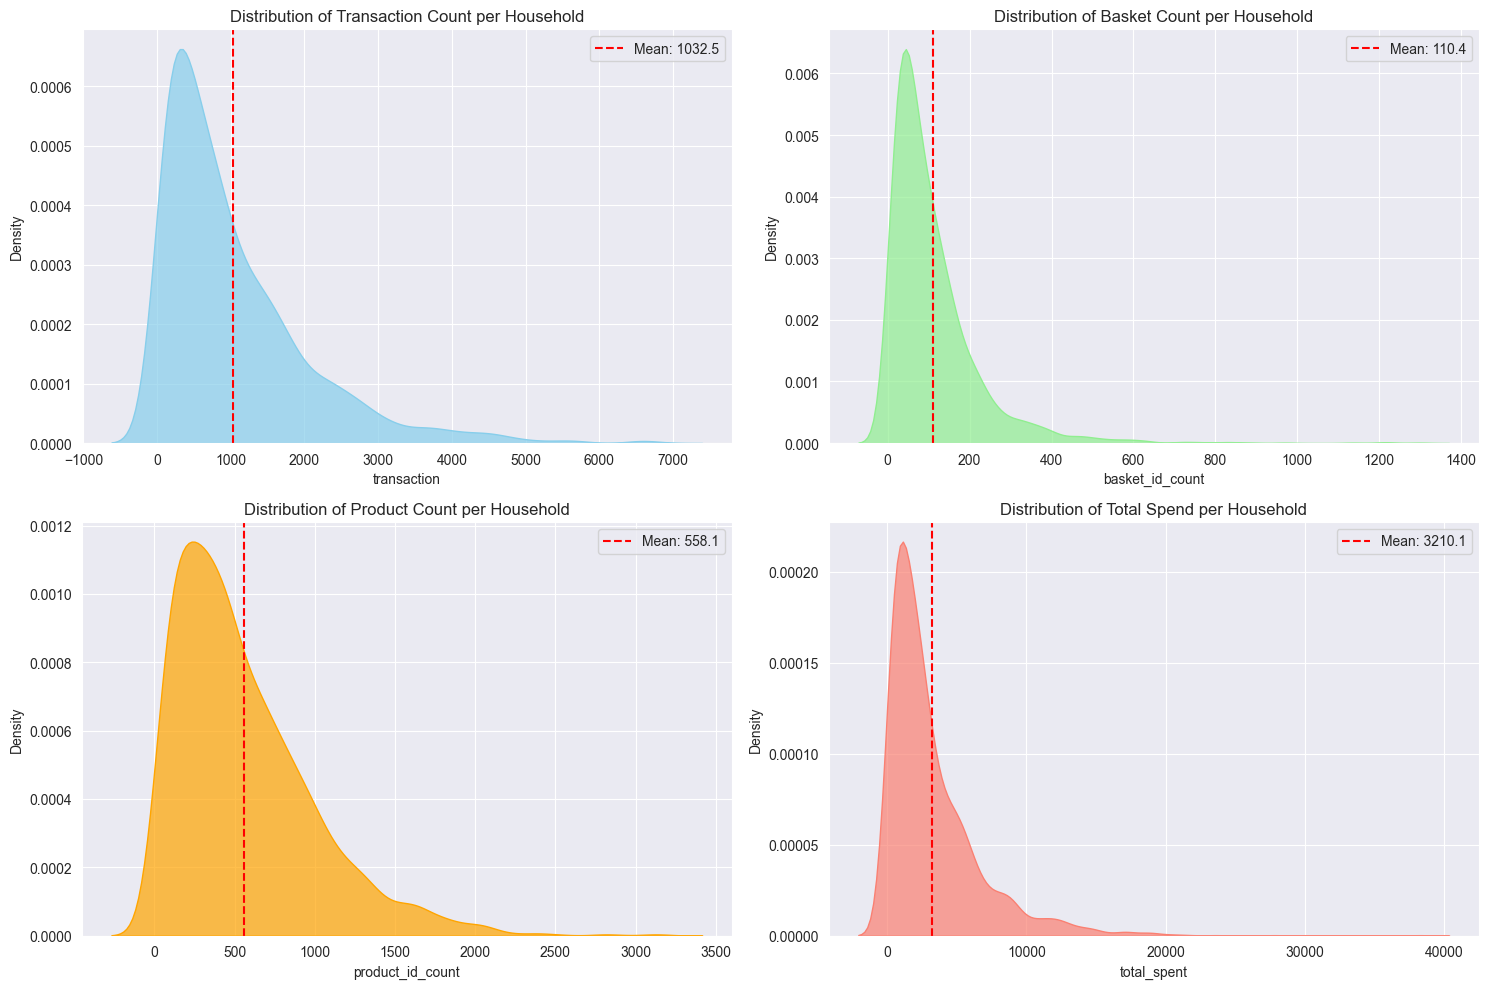

In [16]:
class KDEConfig(NamedTuple):
    col: str
    title: str
    color: str

kde_configs = [
    KDEConfig('transaction', 'Transaction Count', 'skyblue'),
    KDEConfig('basket_id_count', 'Basket Count', 'lightgreen'),
    KDEConfig('product_id_count', 'Product Count', 'orange'),
    KDEConfig('total_spent', 'Total Spend', 'salmon'),
]

def plot_kde(ax, df, config: KDEConfig):
    sns.kdeplot(data=df, x=config.col, ax=ax, fill=True, color=config.color, alpha=0.7)
    mean_val = df[config.col].mean()
    ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.1f}')
    ax.set_title(f'Distribution of {config.title} per Household')
    ax.legend()
    return ax

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
list(map(lambda args: plot_kde(*args), zip(axes.flat, [df_trans_hh] * 4, kde_configs)))
plt.tight_layout()
plt.show()

**Household-level summary:**

- Avg **1,033 transactions**, **110 baskets**, **$3,210 total spent** per household

- High variance: std ≈ mean for most metrics (right-skewed distributions)

- Heavy users: top households have 6,775 transactions, $38K spent

### 2.3 Store-level Analysis

In [44]:
# Store-level 집계
df_trans_store = df_trans.groupby('STORE_ID').agg(**{
    'transaction': ('STORE_ID', 'size'),
    'basket_count': ('BASKET_ID', 'nunique'),
    'customer_count': ('household_key', 'nunique'),
    'total_sales': ('SALES_VALUE', 'sum'),
    'avg_basket_value': ('SALES_VALUE', 'mean')
}).assign(**{
    'sales_per_customer': lambda x: x['total_sales'] / x['customer_count'],
    'baskets_per_customer': lambda x: x['basket_count'] / x['customer_count']
})

print("="*60)
print("STORE-LEVEL METRICS (n=582 stores)")
print("="*60)
print(df_trans_store.describe().round(2).to_markdown())

# Top/Bottom stores
print("\n" + "="*60)
print("TOP 10 STORES BY TOTAL SALES")
print("="*60)
print(df_trans_store.nlargest(10, 'total_sales')[['transaction', 'customer_count', 'total_sales', 'sales_per_customer']].to_markdown())

STORE-LEVEL METRICS (n=582 stores)
|       |   transaction |   basket_count |   customer_count |   total_sales |   avg_basket_value |   sales_per_customer |   baskets_per_customer |
|:------|--------------:|---------------:|-----------------:|--------------:|-------------------:|---------------------:|-----------------------:|
| count |        582    |         582    |           582    |        582    |             582    |               582    |                 582    |
| mean  |       4435.15 |         474.04 |            23.46 |      13844.4  |               4.77 |               231.74 |                   8.31 |
| std   |      10217.1  |        1088.9  |            48.76 |      32845    |               6.47 |               425.23 |                  12.9  |
| min   |          1    |           1    |             1    |          0    |               0    |                 0    |                   1    |
| 25%   |          7    |           1    |             1    |         27.97 |      

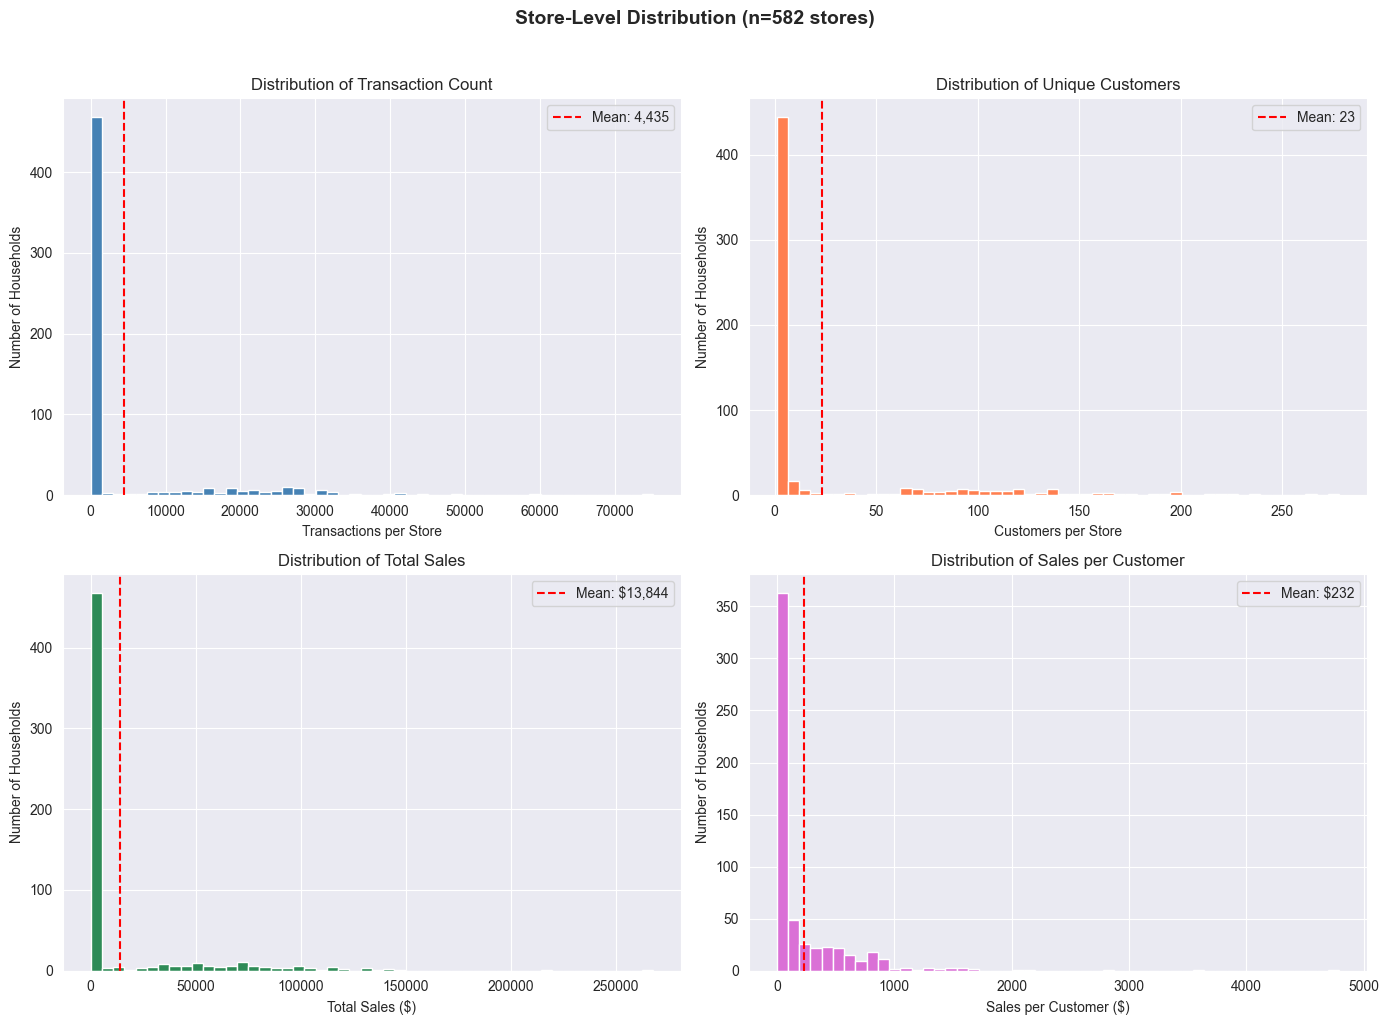


Store Concentration: Top 70 stores (12.0%) account for 80% of total sales


In [45]:
# Store 분포 시각화

# 히스토그램 설정
class HistConfig(NamedTuple):
    col: str
    title: str
    xlabel: str
    color: str
    fmt: str  # mean label format

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

store_hist_configs = [
    HistConfig('transaction', 'Transaction Count', 'Transactions per Store', 'steelblue', '{:,.0f}'),
    HistConfig('customer_count', 'Unique Customers', 'Customers per Store', 'coral', '{:,.0f}'),
    HistConfig('total_sales', 'Total Sales', 'Total Sales ($)', 'seagreen', '${:,.0f}'),
    HistConfig('sales_per_customer', 'Sales per Customer', 'Sales per Customer ($)', 'orchid', '${:,.0f}'),
]

list(map(lambda args: plot_hist(*args), zip(axes.flat, [df_trans_store]*4, store_hist_configs)))
plt.suptitle('Store-Level Distribution (n=582 stores)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Store concentration (Pareto)
store_sales_sorted = df_trans_store['total_sales'].sort_values(ascending=False)
store_cumsum = store_sales_sorted.cumsum() / store_sales_sorted.sum()

top_20_pct = (store_cumsum <= 0.8).sum()
print(f"\nStore Concentration: Top {top_20_pct} stores ({top_20_pct/len(df_trans_store)*100:.1f}%) account for 80% of total sales")

**Store-level summary:**
- **582 stores** with highly skewed distribution

- Median store: 30 transactions, 2 customers, $101 sales

- **Pareto effect**: Top 26 stores (4.5%) account for 80% of total sales

- Top store: $267K sales, 264 customers

### 2.4 Basket-level Analysis

In [46]:
# Basket-level 집계
df_trans_basket = df_trans.groupby('BASKET_ID').agg(**{
    'household_key': ('household_key', 'first'),
    'store_id': ('STORE_ID', 'first'),
    'day': ('DAY', 'first'),
    'items': ('BASKET_ID', 'size'),
    'unique_products': ('PRODUCT_ID', 'nunique'),
    'total_value': ('SALES_VALUE', 'sum'),
    'total_quantity': ('QUANTITY', 'sum'),
    'total_discount': ('RETAIL_DISC', 'sum')
}).assign(**{
    'avg_item_price': lambda x: x['total_value'] / x['items'],
    'discount_rate': lambda x: x['total_discount'] / (x['total_value'] + x['total_discount'])
})

print("="*60)
print("BASKET-LEVEL METRICS (n=275,889 baskets)")
print("="*60)
print(df_trans_basket[['items', 'unique_products', 'total_value', 'total_quantity', 'avg_item_price']].describe().round(2).to_markdown())

BASKET-LEVEL METRICS (n=275,889 baskets)
|       |     items |   unique_products |   total_value |   total_quantity |   avg_item_price |
|:------|----------:|------------------:|--------------:|-----------------:|-----------------:|
| count | 275889    |         275889    |     275889    |        275889    |        275889    |
| mean  |      9.36 |              9.36 |         29.21 |           944.89 |             5.29 |
| std   |     12.24 |             12.24 |         36.11 |          3423.83 |             8.38 |
| min   |      1    |              1    |          0    |             1    |             0    |
| 25%   |      2    |              2    |          6.98 |             3    |             1.99 |
| 50%   |      5    |              5    |         17.15 |             8    |             2.78 |
| 75%   |     12    |             12    |         36.35 |            22    |             4.17 |
| max   |    168    |            168    |        961.49 |         89638    |           499.99 |

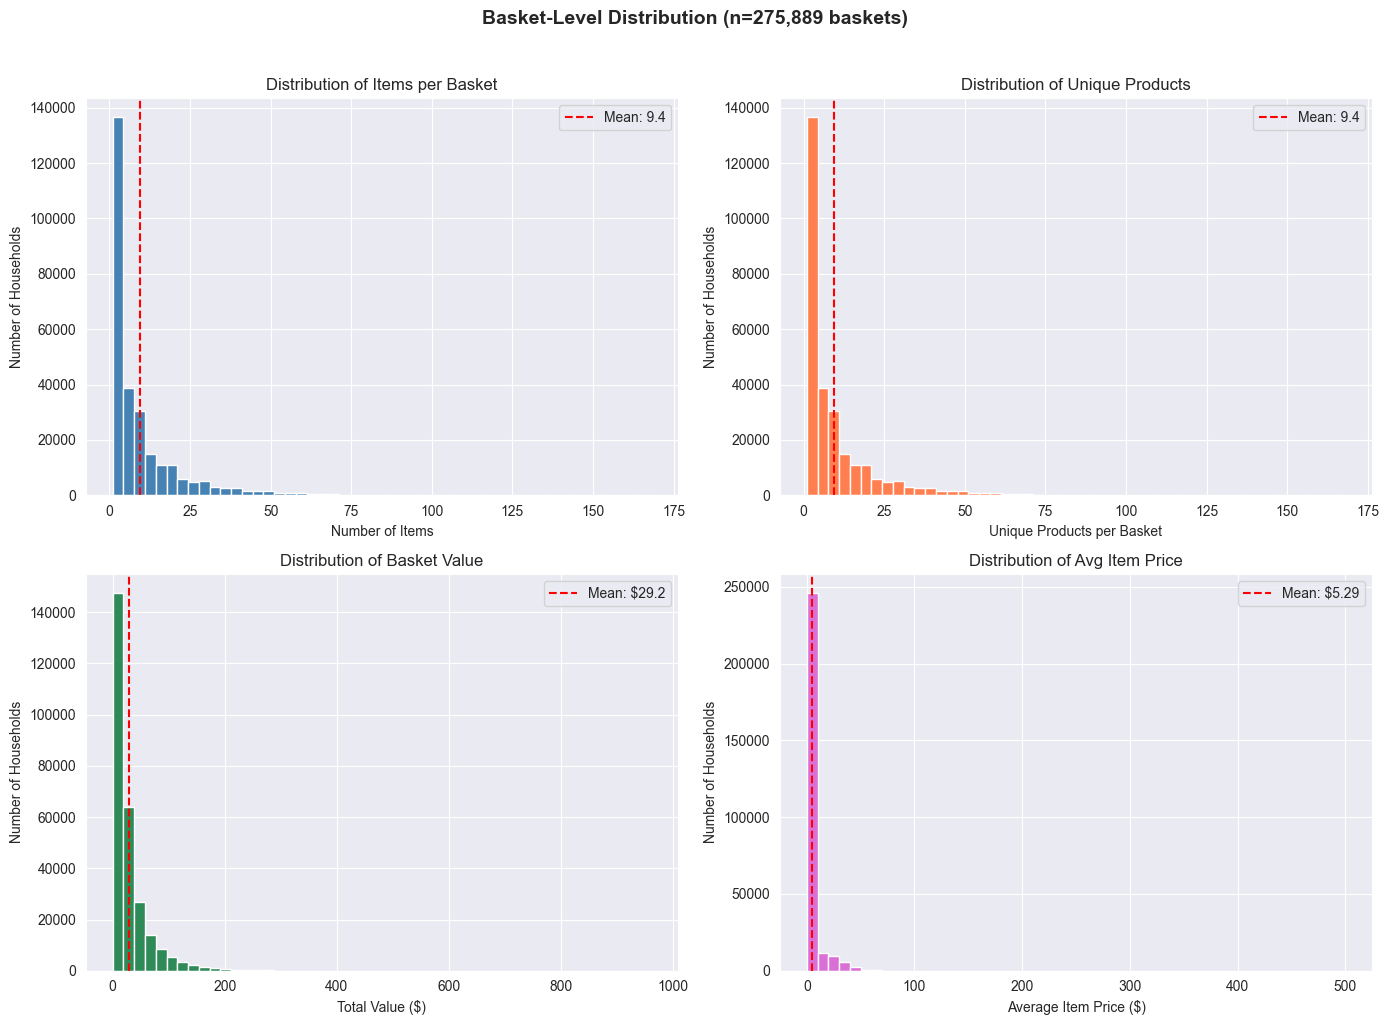


BASKET SIZE DISTRIBUTION
| items   | Proportion   |
|:--------|:-------------|
| 1-5     | 55.0%        |
| 6-10    | 17.2%        |
| 11-20   | 14.8%        |
| 21-50   | 11.2%        |
| 50+     | 1.7%         |


In [47]:
# Basket 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

basket_hist_configs = [
    HistConfig('items', 'Items per Basket', 'Number of Items', 'steelblue', '{:.1f}'),
    HistConfig('unique_products', 'Unique Products', 'Unique Products per Basket', 'coral', '{:.1f}'),
    HistConfig('total_value', 'Basket Value', 'Total Value ($)', 'seagreen', '${:.1f}'),
    HistConfig('avg_item_price', 'Avg Item Price', 'Average Item Price ($)', 'orchid', '${:.2f}'),
]

list(map(lambda args: plot_hist(*args), zip(axes.flat, [df_trans_basket]*4, basket_hist_configs)))
plt.suptitle('Basket-Level Distribution (n=275,889 baskets)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Basket size 분포 요약
print("\n" + "="*60)
print("BASKET SIZE DISTRIBUTION")
print("="*60)
basket_size_bins = pd.cut(df_trans_basket['items'], bins=[0, 5, 10, 20, 50, np.inf], labels=['1-5', '6-10', '11-20', '21-50', '50+'])
print(basket_size_bins.value_counts(normalize=True).sort_index().apply(lambda x: f"{x:.1%}").to_frame('Proportion').to_markdown())

**Basket-level summary:**

- **275,889 baskets** total

- Avg **9.4 items**, **$29.21 value** per basket

- Basket size distribution: 54% have 1-5 items, 22% have 6-10 items

- Avg item price: $5.29 (median $2.78)

### 2.5 Time Trends

In [ ]:
# sales aggregation and dual-axis plot

def agg_trans_by_period(df: pd.DataFrame, period_col: str) -> pd.DataFrame:
    return df.groupby(period_col).agg(**{
        'transaction': ('household_key', 'size'),
        'basket_id_count': ('BASKET_ID', 'nunique'),
        'product_id_count': ('PRODUCT_ID', 'nunique'),
        'total_spend': ('SALES_VALUE', 'sum')
    })

def plot_dual_axis_trend(
    df: pd.DataFrame,
    x_col: str,
    title: str,
    figsize: tuple = (15, 8)
) -> None:
    df_melted = df.reset_index().melt(
        id_vars=[x_col],
        value_vars=['transaction', 'total_spend'],
        var_name='metric',
        value_name='value'
    )

    fig, ax1 = plt.subplots(figsize=figsize)

    # Transaction (left axis)
    sns.lineplot(
        data=df_melted[df_melted['metric'] == 'transaction'],
        x=x_col, y='value', ax=ax1,
        color='tab:blue', marker='o', linewidth=2
    )
    ax1.set_xlabel(x_col, fontsize=12)
    ax1.set_ylabel('Transaction Count', color='tab:blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Total Spend (right axis)
    ax2 = ax1.twinx()
    sns.lineplot(
        data=df_melted[df_melted['metric'] == 'total_spend'],
        x=x_col, y='value', ax=ax2,
        color='tab:red', marker='s', linewidth=2
    )
    ax2.set_ylabel('Total Spend', color='tab:red', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Daily aggregation and plot
df_trans_day = agg_trans_by_period(df_trans, 'DAY')
plot_dual_axis_trend(df_trans_day, 'DAY', 'Daily Transaction Count and Total Spend Trends')

In [ ]:
# Weekly aggregation and plot
df_trans_week = agg_trans_by_period(df_trans, 'WEEK_NO')
plot_dual_axis_trend(df_trans_week, 'WEEK_NO', 'Weekly Transaction Count and Total Spend Trends')

### 2.6 Value-Frequency Segments

In [19]:
df_demo_trans = pd.merge(
    df_demo, df_trans_hh, how='left', on='household_key'
).assign(**{
    'high_spent': lambda elem: np.where(
        elem['total_spent'] > df_trans_hh['total_spent'].quantile(0.75), 1, 0
    ), 'high_visit': lambda elem: np.where(
        elem['basket_id_count'] > df_trans_hh['basket_id_count'].quantile(0.75), 1, 0
    )
})
df_demo_trans.head()

,AGE_GRP,MARITAL,INCOME_GRP,HOMEOWNER_DESC,HOUSEHOLD_COMPOSITION,HOUSEHOLD_SIZE,KID_CATEGORY_DESC,household_key,transaction,basket_id_count,product_id_count,coupon_disc,total_spent,high_spent,high_visit
0,Age Group6,X,Level4,Homeowner,Group5,2,None/Unknown,1,1710,85,674,73.31,4256.85,0,0
1,Age Group4,X,Level5,Homeowner,Group5,2,None/Unknown,7,1280,59,826,22.40,3377.65,0,0
2,Age Group2,Y,Level3,Unknown,Group4,3,1,8,1967,113,1282,21.85,5513.12,1,0
3,Age Group2,Y,Level6,Homeowner,Group4,4,2,13,2293,275,1006,238.97,12951.95,1,1
4,Age Group4,Z,Level5,Homeowner,Group3,1,None/Unknown,16,517,98,282,1.00,1511.02,0,0


In [31]:
tableone_cols = ['AGE_GRP', 'MARITAL', 'INCOME_GRP', 'HOMEOWNER_DESC', 'HOUSEHOLD_COMPOSITION', 'HOUSEHOLD_SIZE', 'KID_CATEGORY_DESC']

filter_tableone(
    compute_tableone(
        df_demo_trans, 'high_spent', tableone_cols,
        categorical=tableone_cols, expand_categorical=True, effect_size=False
    ), p_threshold=0.05
)

,Variable,Category,Overall,0 (n=374),1 (n=427),Test,Statistic,P-value
0,AGE_GRP,Age Group1,46 (5.7%),24 (6.4%),22 (5.2%),Chi-squared,17.71,0.003
1,,Age Group2,142 (17.7%),64 (17.1%),78 (18.3%),,,
2,,Age Group3,194 (24.2%),75 (20.1%),119 (27.9%),,,
3,,Age Group4,288 (36.0%),133 (35.6%),155 (36.3%),,,
4,,Age Group5,59 (7.4%),30 (8.0%),29 (6.8%),,,
5,,Age Group6,72 (9.0%),48 (12.8%),24 (5.6%),,,
6,INCOME_GRP,Level1,61 (7.6%),26 (7.0%),35 (8.2%),Chi-squared,40.58,<0.001
7,,Level10,11 (1.4%),5 (1.3%),6 (1.4%),,,
8,,Level11,5 (0.6%),2 (0.5%),3 (0.7%),,,
9,,Level12,11 (1.4%),2 (0.5%),9 (2.1%),,,


In [32]:
tableone_cols = ['AGE_GRP', 'MARITAL', 'INCOME_GRP', 'HOMEOWNER_DESC', 'HOUSEHOLD_COMPOSITION', 'HOUSEHOLD_SIZE', 'KID_CATEGORY_DESC']

filter_tableone(
    compute_tableone(
        df_demo_trans, 'high_visit', tableone_cols,
        categorical=tableone_cols, expand_categorical=True, effect_size=False
    ), p_threshold=0.05
)

,Variable,Category,Overall,0 (n=413),1 (n=388),Test,Statistic,P-value
0,MARITAL,X,340 (42.4%),192 (46.5%),148 (38.1%),Chi-squared,9.34,0.009
1,,Y,344 (42.9%),156 (37.8%),188 (48.5%),,,
2,,Z,117 (14.6%),65 (15.7%),52 (13.4%),,,
3,HOMEOWNER_DESC,Homeowner,504 (62.9%),283 (68.5%),221 (57.0%),Chi-squared,12.74,0.01
4,,Probable Owner,11 (1.4%),5 (1.2%),6 (1.5%),,,
5,,Probable Renter,11 (1.4%),5 (1.2%),6 (1.5%),,,
6,,Renter,42 (5.2%),15 (3.6%),27 (7.0%),,,
7,,Unknown,233 (29.1%),105 (25.4%),128 (33.0%),,,


SPENDING × VISIT CROSS-SEGMENT ANALYSIS
| cross_segment   |   Count |   Pct |   Avg Baskets |   Avg Spent ($) |   Spend per Visit |   Avg Coupon Disc ($) |
|:----------------|--------:|------:|--------------:|----------------:|------------------:|----------------------:|
| High-Frequent   |     295 | 36.83 |        275.7  |         8828.37 |             32.02 |                 40.22 |
| High-Occasional |     132 | 16.48 |        109.42 |         6284.85 |             57.44 |                 33.46 |
| Low-Frequent    |      93 | 11.61 |        203.6  |         3010.64 |             14.79 |                 11.53 |
| Low-Occasional  |     281 | 35.08 |         90.15 |         2713.88 |             30.11 |                 13.49 |


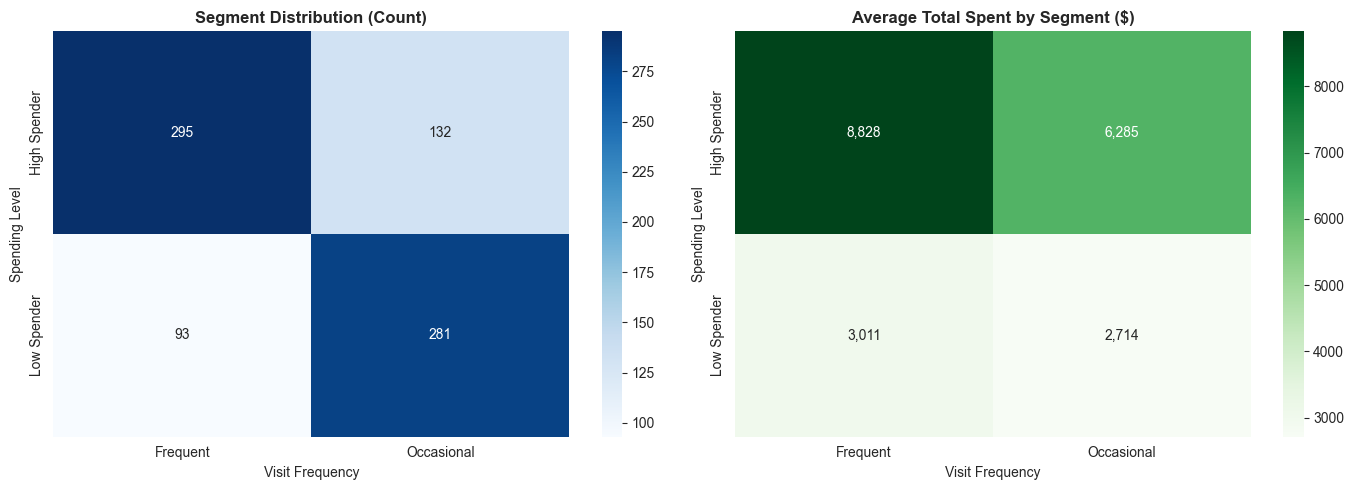

In [48]:
# Spending × Visit 교차 세그먼트 분석
df_demo_trans = df_demo_trans.assign(**{
    'cross_segment': lambda x: np.select(
        [
            (x['high_spent'] == 1) & (x['high_visit'] == 1),
            (x['high_spent'] == 1) & (x['high_visit'] == 0),
            (x['high_spent'] == 0) & (x['high_visit'] == 1),
            (x['high_spent'] == 0) & (x['high_visit'] == 0)
        ],
        ['High-Frequent', 'High-Occasional', 'Low-Frequent', 'Low-Occasional'],
        default='Unknown'
    )
})

# 세그먼트별 요약
segment_summary = df_demo_trans.groupby('cross_segment').agg(**{
    'Count': ('household_key', 'size'),
    'Avg Transactions': ('transaction', 'mean'),
    'Avg Baskets': ('basket_id_count', 'mean'),
    'Avg Spent ($)': ('total_spent', 'mean'),
    'Avg Products': ('product_id_count', 'mean'),
    'Avg Coupon Disc ($)': ('coupon_disc', 'mean')
}).assign(**{
    'Pct': lambda x: x['Count'] / x['Count'].sum() * 100,
    'Spend per Visit': lambda x: x['Avg Spent ($)'] / x['Avg Baskets']
}).round(2)

# 세그먼트 순서 정렬
segment_order = ['High-Frequent', 'High-Occasional', 'Low-Frequent', 'Low-Occasional']
segment_summary = segment_summary.reindex(segment_order)

print("="*60)
print("SPENDING × VISIT CROSS-SEGMENT ANALYSIS")
print("="*60)
print(segment_summary[['Count', 'Pct', 'Avg Baskets', 'Avg Spent ($)', 'Spend per Visit', 'Avg Coupon Disc ($)']].to_markdown())

# Heatmap 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) 세그먼트 분포 히트맵
cross_table = pd.crosstab(
    df_demo_trans['high_spent'].map({0: 'Low Spender', 1: 'High Spender'}),
    df_demo_trans['high_visit'].map({0: 'Occasional', 1: 'Frequent'}),
    margins=True
)
sns.heatmap(cross_table.iloc[:-1, :-1], annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Segment Distribution (Count)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Visit Frequency')
axes[0].set_ylabel('Spending Level')

# 2) 세그먼트별 평균 지출 히트맵
spend_pivot = df_demo_trans.pivot_table(
    values='total_spent', 
    index=df_demo_trans['high_spent'].map({0: 'Low Spender', 1: 'High Spender'}),
    columns=df_demo_trans['high_visit'].map({0: 'Occasional', 1: 'Frequent'}),
    aggfunc='mean'
)
sns.heatmap(spend_pivot, annot=True, fmt=',.0f', cmap='Greens', ax=axes[1])
axes[1].set_title('Average Total Spent by Segment ($)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Visit Frequency')
axes[1].set_ylabel('Spending Level')

plt.tight_layout()
plt.show()

**High vs Low Spenders/Visitors summary:**
- **High spenders** differ significantly by:
  - `AGE_GRP` (p=0.003): fewer Age Group6, more Age Group3
  - `INCOME_GRP` (p<0.001): fewer Level2-4, more Level7-12
- **High visitors** differ by:
  - `MARITAL` (p=0.009): more Y, fewer X
  - `HOMEOWNER_DESC` (p=0.01): fewer Homeowners, more Renters/Unknown
- **Cross-segments** (Spending × Visit):
  - High-Frequent: 24%, avg $9,208 spent, $41/visit
  - Low-Occasional: 30%, avg $1,596 spent, $28/visit

### 2.7 Discount Sensitivity

In [34]:
df_trans_discount = df_trans.assign(**{
    'total_discount': lambda x: x['RETAIL_DISC'] + x['COUPON_DISC'] + x['COUPON_MATCH_DISC'],
    'customer_paid': lambda x: x['SALES_VALUE'] - x['COUPON_DISC'],
}).assign(**{
    'original_cost': lambda x: x['customer_paid'] + x['total_discount'],
    'discount_rate': lambda x: np.where(
        x['customer_paid'] + x['total_discount'] > 0,
        x['total_discount'] / (x['customer_paid'] + x['total_discount']),
        0
    ),
    'is_discounted': lambda x: (x['total_discount'] > 0).astype(int)
})


print("="*60)
print("DISCOUNT METRICS - TRANSACTION LEVEL")
print("="*60)
print(f"\n # of total transactions: {len(df_trans_discount):,}")
print(f" # of discounted transactions: {df_trans_discount['is_discounted'].sum():,} ({100*df_trans_discount['is_discounted'].mean():.1f}%)")
print(f"\n Avg. discount rate: {df_trans_discount[df_trans_discount['is_discounted']==1]['discount_rate'].mean():.1%}")
print(f" Avg. discount cost: ${df_trans_discount['total_discount'].mean():.2f}")


print("\n" + "="*60)
print("DISCOUNT TYPE DISTRIBUTION")
print("="*60)
discount_types = pd.DataFrame({
    'Type': ['RETAIL_DISC', 'COUPON_DISC', 'COUPON_MATCH_DISC'],
    'Non-zero Count': [
        (df_trans_discount['RETAIL_DISC'] > 0).sum(),
        (df_trans_discount['COUPON_DISC'] > 0).sum(),
        (df_trans_discount['COUPON_MATCH_DISC'] > 0).sum()
    ],
    'Mean (when applied)': [
        df_trans_discount[df_trans_discount['RETAIL_DISC'] > 0]['RETAIL_DISC'].mean(),
        df_trans_discount[df_trans_discount['COUPON_DISC'] > 0]['COUPON_DISC'].mean(),
        df_trans_discount[df_trans_discount['COUPON_MATCH_DISC'] > 0]['COUPON_MATCH_DISC'].mean()
    ]
})
discount_types['Pct of Transactions'] = discount_types['Non-zero Count'] / len(df_trans_discount) * 100
print(discount_types.round(2).to_markdown(index=False))

DISCOUNT METRICS - TRANSACTION LEVEL

 # of total transactions: 2,581,260
 # of discounted transactions: 1,314,435 (50.9%)

 Avg. discount rate: 27.2%
 Avg. discount cost: $0.56

DISCOUNT TYPE DISTRIBUTION
| Type              |   Non-zero Count |   Mean (when applied) |   Pct of Transactions |
|:------------------|-----------------:|----------------------:|----------------------:|
| RETAIL_DISC       |          1303017 |                  1.07 |                 50.48 |
| COUPON_DISC       |            31467 |                  1.03 |                  1.22 |
| COUPON_MATCH_DISC |            17449 |                  0.43 |                  0.68 |


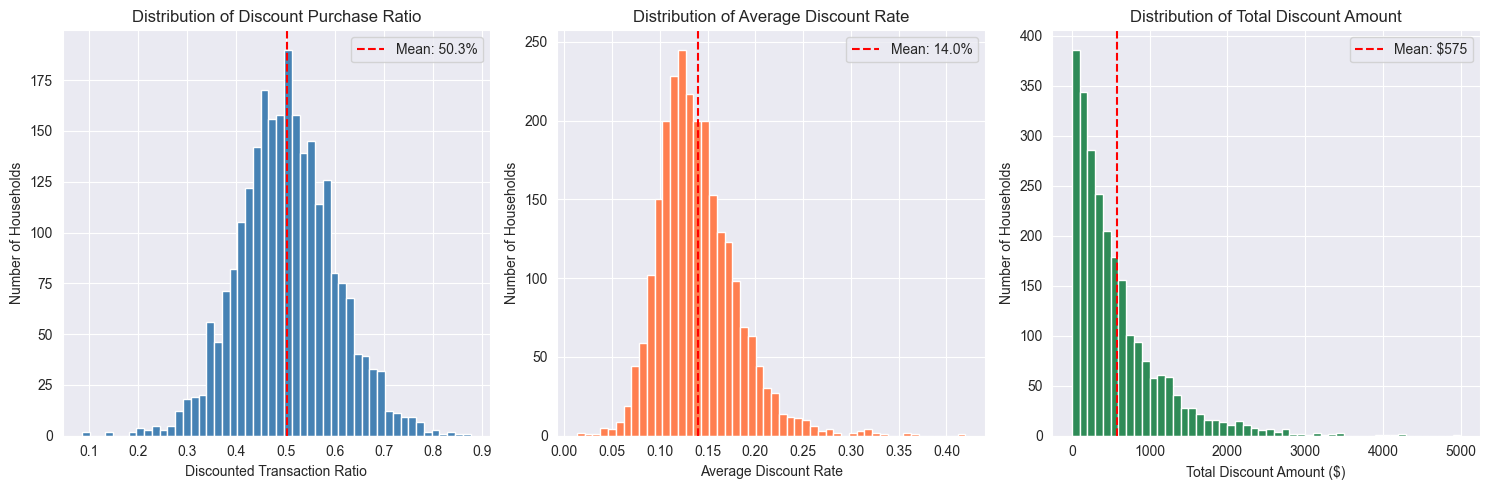

|       |   pct_discounted_trans |   avg_discount_rate |   total_discount_amount |
|:------|-----------------------:|--------------------:|------------------------:|
| count |               2500     |            2500     |                2500     |
| mean  |                  0.503 |               0.14  |                 575.28  |
| std   |                  0.098 |               0.041 |                 587.62  |
| min   |                  0.086 |               0.013 |                   0.25  |
| 25%   |                  0.439 |               0.112 |                 168.522 |
| 50%   |                  0.5   |               0.134 |                 395.665 |
| 75%   |                  0.565 |               0.161 |                 774.815 |
| max   |                  0.876 |               0.42  |                4995.37  |


In [39]:
df_discount_hh = df_trans_discount.groupby('household_key').agg(**{
    'total_transactions': ('household_key', 'size'),
    'discounted_transactions': ('is_discounted', 'sum'),
    'total_discount_amount': ('total_discount', 'sum'),
    'avg_discount_rate': ('discount_rate', 'mean'),
    'total_spent': ('customer_paid', 'sum')
}).assign(**{
    'pct_discounted_trans': lambda x: x['discounted_transactions'] / x['total_transactions'],
    'discount_per_transaction': lambda x: x['total_discount_amount'] / x['total_transactions']
})

class HistConfig(NamedTuple):
    col: str
    title: str
    xlabel: str
    color: str
    fmt: str  # mean label format

hist_configs = [
    HistConfig('pct_discounted_trans', 'Discount Purchase Ratio', 'Discounted Transaction Ratio', 'steelblue', '{:.1%}'),
    HistConfig('avg_discount_rate', 'Average Discount Rate', 'Average Discount Rate', 'coral', '{:.1%}'),
    HistConfig('total_discount_amount', 'Total Discount Amount', 'Total Discount Amount ($)', 'seagreen', '${:.0f}'),
]

def plot_hist(ax, df, cfg: HistConfig):
    ax.hist(df[cfg.col], bins=50, color=cfg.color, edgecolor='white')
    mean_val = df[cfg.col].mean()
    ax.axvline(mean_val, color='red', linestyle='--', label=f"Mean: {cfg.fmt.format(mean_val)}")
    ax.set_xlabel(cfg.xlabel)
    ax.set_ylabel('Number of Households')
    ax.set_title(f'Distribution of {cfg.title}')
    ax.legend()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
list(map(lambda args: plot_hist(*args), zip(axes, [df_discount_hh]*3, hist_configs)))
plt.tight_layout()
plt.show()

print(df_discount_hh[['pct_discounted_trans', 'avg_discount_rate', 'total_discount_amount']].describe().round(3).to_markdown())

In [41]:
# Step 3: 민감도 세그먼트 정의 (percentile 기반)
segment_labels = ['Price Insensitive', 'Occasional Savers', 'Deal Seekers']

df_discount_hh = df_discount_hh.assign(**{
    'sensitivity_segment': lambda x: pd.qcut(
        x['pct_discounted_trans'], q=3, labels=segment_labels
    )
})

# 세그먼트 요약
segment_summary = df_discount_hh.groupby('sensitivity_segment', observed=True).agg(**{
    'Count': ('total_transactions', 'size'),
    'Discount Ratio Range': ('pct_discounted_trans', lambda x: f"{x.min():.1%} - {x.max():.1%}"),
    'Avg Transactions': ('total_transactions', 'mean'),
    'Avg Spent ($)': ('total_spent', 'mean'),
    'Avg Discount Rate': ('avg_discount_rate', 'mean'),
    'Avg Discount ($)': ('total_discount_amount', 'mean')
}).assign(**{'Pct': lambda x: x['Count'] / x['Count'].sum() * 100}).round(2)

print("="*60)
print("DISCOUNT SENSITIVITY SEGMENTS (Tertile-based)")
print("="*60)
print(segment_summary[['Count', 'Pct', 'Discount Ratio Range', 'Avg Transactions', 'Avg Spent ($)', 'Avg Discount Rate', 'Avg Discount ($)']].to_markdown())

DISCOUNT SENSITIVITY SEGMENTS (Tertile-based)
| sensitivity_segment   |   Count |   Pct | Discount Ratio Range   |   Avg Transactions |   Avg Spent ($) |   Avg Discount Rate |   Avg Discount ($) |
|:----------------------|--------:|------:|:-----------------------|-------------------:|----------------:|--------------------:|-------------------:|
| Price Insensitive     |     834 | 33.36 | 8.6% - 46.0%           |             947.07 |         3164.58 |                0.1  |             398.78 |
| Occasional Savers     |     833 | 33.32 | 46.0% - 54.2%          |            1074.27 |         3311.34 |                0.14 |             567.2  |
| Deal Seekers          |     833 | 33.32 | 54.2% - 87.6%          |            1076.27 |         3154.3  |                0.18 |             760.07 |


In [49]:
# Step 4: 세그먼트별 인구통계 비교 (Deal Seekers vs Price Insensitive)
df_discount_demo = pd.merge(
    df_demo,
    df_discount_hh.reset_index()[['household_key', 'sensitivity_segment', 'pct_discounted_trans', 'total_spent']],
    on='household_key',
    how='inner'
)

# Deal Seekers vs Price Insensitive 비교 (binary)
df_discount_demo_binary = df_discount_demo[
    df_discount_demo['sensitivity_segment'].isin(['Deal Seekers', 'Price Insensitive'])
].assign(**{
    'is_deal_seeker': lambda x: (x['sensitivity_segment'] == 'Deal Seekers').astype(int)
})

print("="*60)
print("DEMOGRAPHIC COMPARISON: Deal Seekers vs Price Insensitive")
print("="*60)
print(f"\nDeal Seekers: {(df_discount_demo_binary['is_deal_seeker']==1).sum()}")
print(f"Price Insensitive: {(df_discount_demo_binary['is_deal_seeker']==0).sum()}")

tableone_cols = ['AGE_GRP', 'MARITAL', 'INCOME_GRP', 'HOMEOWNER_DESC', 'HOUSEHOLD_SIZE', 'KID_CATEGORY_DESC']

result = filter_tableone(
    compute_tableone(
        df_discount_demo_binary, 'is_deal_seeker', tableone_cols,
        categorical=tableone_cols, expand_categorical=True, effect_size=False
    ), p_threshold=0.1
)

print("\n" + "="*60)
print("SIGNIFICANT DIFFERENCES (p < 0.1)")
print("="*60)
if len(result) > 0:
    print(result.to_markdown(index=False))
else:
    print("No significant differences found.")

DEMOGRAPHIC COMPARISON: Deal Seekers vs Price Insensitive

Deal Seekers: 273
Price Insensitive: 262

SIGNIFICANT DIFFERENCES (p < 0.1)
| Variable          | Category     | Overall     | 0 (n=262)   | 1 (n=273)   | Test                                | Statistic   | P-value   |
|:------------------|:-------------|:------------|:------------|:------------|:------------------------------------|:------------|:----------|
| AGE_GRP           | Age Group1   | 27 (5.0%)   | 11 (4.2%)   | 16 (5.9%)   | Chi-squared                         | 15.08       | 0.01      |
|                   | Age Group2   | 93 (17.4%)  | 48 (18.3%)  | 45 (16.5%)  |                                     |             |           |
|                   | Age Group3   | 134 (25.0%) | 53 (20.2%)  | 81 (29.7%)  |                                     |             |           |
|                   | Age Group4   | 189 (35.3%) | 96 (36.6%)  | 93 (34.1%)  |                                     |             |           |
|      

**Summary: Discount Sensitivity Analysis**
- **Transaction-level:** 50.9% discounted, avg 27.2% discount rate (when applied)
- **Discount types:** RETAIL_DISC dominates (50.5%), COUPON_DISC rare (1.2%)
- **Sensitivity segments** (tertile-based):
  - Price Insensitive: 8.6-46% discount ratio, avg $399 discount
  - Occasional Savers: 46-54% discount ratio, avg $567 discount
  - Deal Seekers: 54-88% discount ratio, avg $760 discount
- **Deal Seekers vs Price Insensitive differ by:**
  - `AGE_GRP` (p=0.01): Deal Seekers younger (more Group3, fewer Group6)
  - `INCOME_GRP` (p<0.001): Deal Seekers lower-mid income (Level3-5)
  - `KID_CATEGORY_DESC` (p=0.01): Deal Seekers more likely to have kids